<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/TransferLearningUsingKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, math, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE

In [2]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.14.0-rc1


In [0]:
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in tf.keras.applications.* are not yet TPU-compatible"

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [ 192, 192]

BATCH_SIZE=64 # 128 may cause Colab memory issue
EPOCHS = 5
VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [7]:
# split train and validationset
filenames = tf.gfile.Glob(GCS_PATTERN)

split = int( len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(
    len(filenames), len(training_filenames), len(validation_filenames)))


Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files


In [9]:
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch =  int(3670 // len(filenames) * len(training_filenames  )) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

In [0]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', should be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [0]:
training_dataset = get_batched_dataset(training_filenames)

In [0]:
validation_dataset = get_batched_dataset(validation_filenames)

W0618 00:58:50.541430 139862663681920 deprecation.py:323] From <ipython-input-16-653a9cc533c1>:14: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


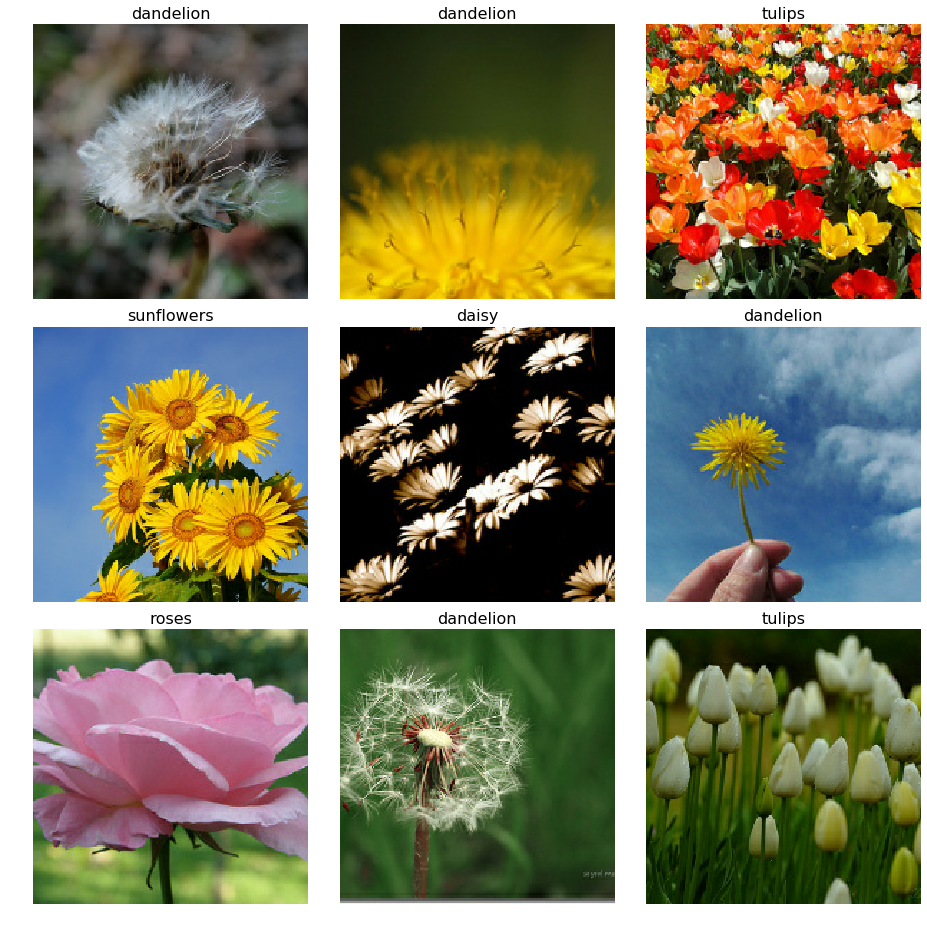

In [17]:
display_9_images_from_dataset(load_dataset(training_filenames))

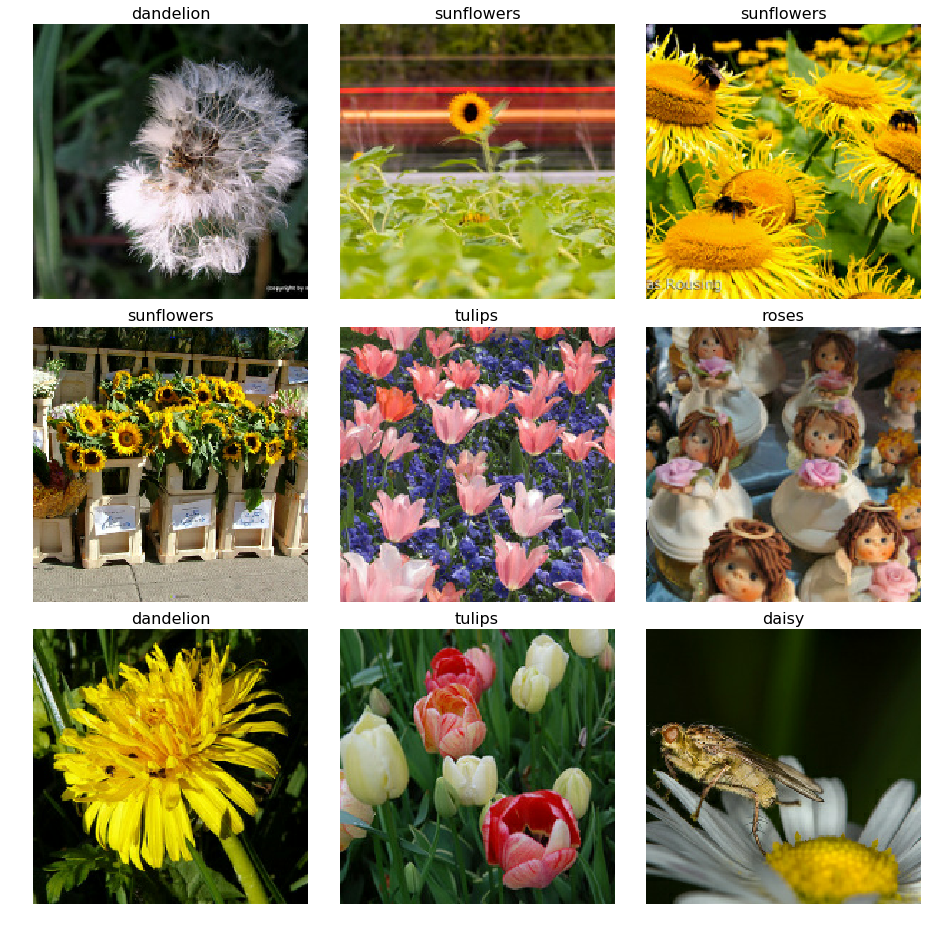

In [18]:
display_9_images_from_dataset(load_dataset(validation_filenames))

In [20]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)

W0618 01:07:25.982193 139862663681920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


9412608/9406464 [==============================] - 1s 0us/step


In [0]:
pretrained_model.trainable = False

In [22]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
history = model.fit(
    training_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs=EPOCHS,
    validation_data = validation_dataset, 
    validation_steps = validation_steps
)

Epoch 1/5
46/46 [==============================] - 59s 1s/step - loss: 1.3891 - acc: 0.7714 - val_loss: 1.6786 - val_acc: 0.7688
Epoch 2/5
46/46 [==============================] - 4s 92ms/step - loss: 0.3186 - acc: 0.9355 - val_loss: 2.4418 - val_acc: 0.7234
Epoch 3/5
46/46 [==============================] - 4s 88ms/step - loss: 0.1172 - acc: 0.9715 - val_loss: 2.6227 - val_acc: 0.7203
Epoch 4/5
46/46 [==============================] - 4s 92ms/step - loss: 0.0907 - acc: 0.9793 - val_loss: 3.6869 - val_acc: 0.6828
Epoch 5/5
46/46 [==============================] - 4s 85ms/step - loss: 0.0674 - acc: 0.9844 - val_loss: 3.4955 - val_acc: 0.7109


In [35]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [36]:
history.history['val_loss']

[1.6786159515380858,
 2.441824162006378,
 2.6227160930633544,
 3.6868937015533447,
 3.495530533790588]

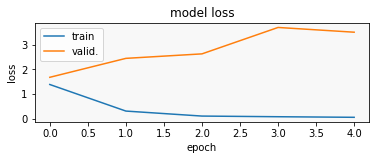

In [37]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [0]:
flowers, label = dataset_to_numpy_util(load_dataset(validation_filenames), 10)

In [41]:
pred = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(pred, axis=-1)])

['sunflowers' 'tulips' 'sunflowers' 'roses' 'sunflowers' 'sunflowers'
 'tulips' 'daisy' 'daisy' 'sunflowers']


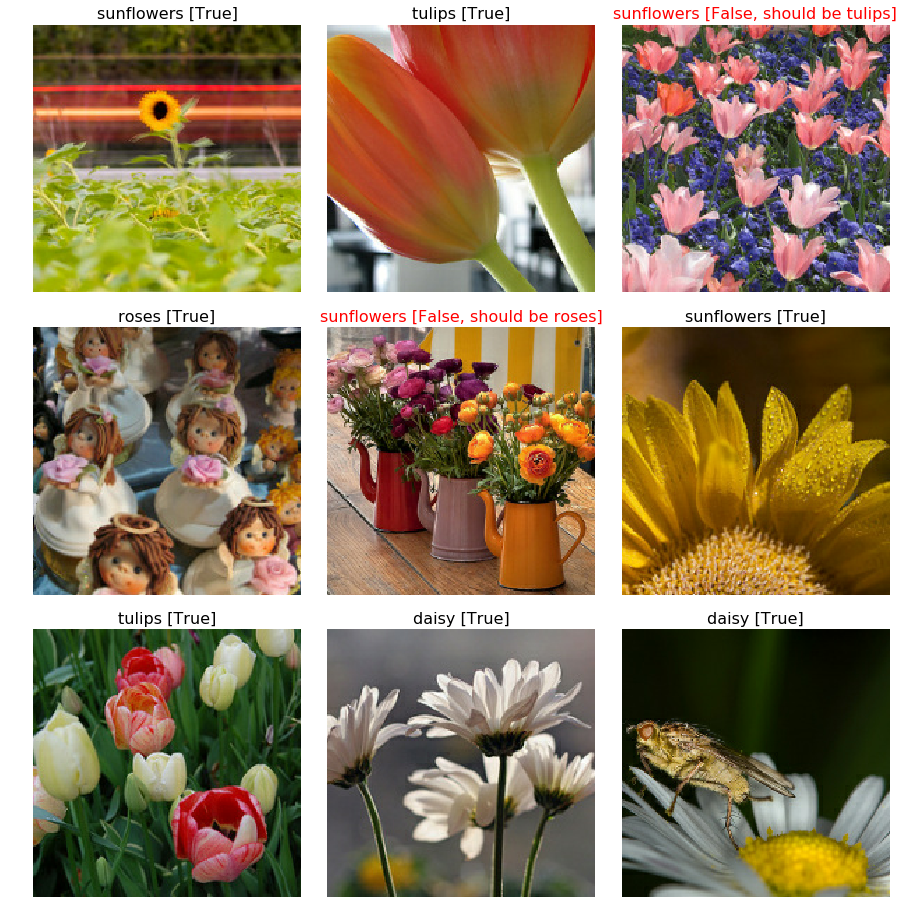

In [44]:
display_9_images_with_predictions(flowers, pred, label)

In [45]:
# VGG16

pretrained_model = tf.keras.applications.VGG16(input_shape=[*IMAGE_SIZE, 3], include_top=False)

58892288/58889256 [==============================] - 4s 0us/step


In [47]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')    
])

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 92165     
Total params: 14,806,853
Trainable params: 14,806,853
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(
    training_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps = validation_steps
)

Epoch 1/5
46/46 [==============================] - 69s 1s/step - loss: 1.6530 - acc: 0.2996 - val_loss: 1.2853 - val_acc: 0.4578
Epoch 2/5
46/46 [==============================] - 32s 697ms/step - loss: 1.2929 - acc: 0.4406 - val_loss: 1.2845 - val_acc: 0.4469
Epoch 3/5
46/46 [==============================] - 32s 693ms/step - loss: 1.1881 - acc: 0.5065 - val_loss: 1.1585 - val_acc: 0.5469
Epoch 4/5
46/46 [==============================] - 32s 693ms/step - loss: 1.1324 - acc: 0.5299 - val_loss: 1.1439 - val_acc: 0.5328
Epoch 5/5
46/46 [==============================] - 32s 691ms/step - loss: 1.0708 - acc: 0.5598 - val_loss: 1.1356 - val_acc: 0.5453


In [0]:
# VCC16 performed poorly compared to Mobilenet despite the former had more parameters to train

In [0]:
#VGG 16 with imagenet weights

pretrained_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=[*IMAGE_SIZE, 3], include_top = False)

In [54]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 92165     
Total params: 14,806,853
Trainable params: 14,806,853
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(
    training_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs = EPOCHS,
    validation_data = validation_dataset,
    validation_steps = validation_steps
)

Epoch 1/5
46/46 [==============================] - 50s 1s/step - loss: 1.6802 - acc: 0.2459 - val_loss: 1.5541 - val_acc: 0.2766
Epoch 2/5
46/46 [==============================] - 32s 686ms/step - loss: 1.3669 - acc: 0.4069 - val_loss: 1.2534 - val_acc: 0.4641
Epoch 3/5
46/46 [==============================] - 32s 695ms/step - loss: 1.1710 - acc: 0.4949 - val_loss: 1.3425 - val_acc: 0.4641
Epoch 4/5
46/46 [==============================] - 32s 693ms/step - loss: 1.1187 - acc: 0.5238 - val_loss: 1.0720 - val_acc: 0.5688
Epoch 5/5
46/46 [==============================] - 32s 688ms/step - loss: 1.0521 - acc: 0.5686 - val_loss: 1.0256 - val_acc: 0.5875


In [59]:
# ResNet50
pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [60]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 6, 6, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 368645    
Total params: 23,956,357
Trainable params: 23,903,237
Non-trainable params: 53,120
_________________________________________________________________


In [61]:
history = model.fit(
    training_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs = EPOCHS,
    validation_data = validation_dataset,
    validation_steps = validation_steps
)

Epoch 1/5
46/46 [==============================] - 66s 1s/step - loss: 4.0651 - acc: 0.6522 - val_loss: 313961344.0000 - val_acc: 0.2406
Epoch 2/5
46/46 [==============================] - 29s 627ms/step - loss: 3.0141 - acc: 0.5893 - val_loss: 155499.2500 - val_acc: 0.2344
Epoch 3/5
46/46 [==============================] - 29s 622ms/step - loss: 2.3938 - acc: 0.6029 - val_loss: 5976.1684 - val_acc: 0.2313
Epoch 4/5
46/46 [==============================] - 28s 619ms/step - loss: 2.3539 - acc: 0.6315 - val_loss: 2.7087 - val_acc: 0.2375
Epoch 5/5
46/46 [==============================] - 29s 622ms/step - loss: 1.7625 - acc: 0.6301 - val_loss: 695.7262 - val_acc: 0.2047


In [0]:
# ResNet50 performs badly 

In [62]:
# MobileNet
pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

17227776/17225924 [==============================] - 2s 0us/step


In [63]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_192 (Model)   (None, 6, 6, 1024)        3228864   
_________________________________________________________________
flatten_7 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 184325    
Total params: 3,413,189
Trainable params: 3,391,301
Non-trainable params: 21,888
_________________________________________________________________


In [64]:
history = model.fit(
    training_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs = EPOCHS,
    validation_data = validation_dataset,
    validation_steps = validation_steps
)

Epoch 1/5
46/46 [==============================] - 55s 1s/step - loss: 2.1079 - acc: 0.7741 - val_loss: 17.1601 - val_acc: 0.5328
Epoch 2/5
46/46 [==============================] - 16s 348ms/step - loss: 0.6158 - acc: 0.9032 - val_loss: 9.9131 - val_acc: 0.6344
Epoch 3/5
46/46 [==============================] - 16s 341ms/step - loss: 0.1812 - acc: 0.9609 - val_loss: 4.4822 - val_acc: 0.7672
Epoch 4/5
46/46 [==============================] - 16s 340ms/step - loss: 0.0979 - acc: 0.9772 - val_loss: 1.9181 - val_acc: 0.8562
Epoch 5/5
46/46 [==============================] - 16s 339ms/step - loss: 0.0635 - acc: 0.9793 - val_loss: 1.8713 - val_acc: 0.8719
